<a href="https://colab.research.google.com/github/VVKate/Neural_University_HomeWorks/blob/main/10_%D0%92%D0%B0%D1%80%D0%B8%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D0%B0%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D1%89%D0%B8%D0%BA%D0%B8%2C_%D0%B3%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D1%8B%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8_%D0%BD%D0%B0_%D0%B1%D0%B0%D0%B7%D0%B5_%D0%B0%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D1%89%D0%B8%D0%BA%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнеее задание: Июльский курс (2020). Pro. Занятие 10
# Вариационные автокодировщики, генеративные модели на базе автокодировщиков
## Верхошинская Катерина Викторовна

## **LIGHT**

### **Задание:**

Используйте готовый ноутбуки с VAE и CVAE с занятия
1. Попробуйте разные размеры скрытого пространства VAE - 10, 20, 100, 200, опишите результаты сравнения
2. Сделайте свёрточный VAE, опишите разницу результатов с полносвязным
3. Сделайте более мощный CVAE, обучите больше эпох до более низкого уровня ошибки и сравните изображения, которые получаются в итоге, коррелирует ли уровень ошибки с качеством изображений
4. Подайте 5 раз в decoder CVAE один и тот же случайный вектор и label любой от 0 до 9 на выбор, посмотрите, что сгенерирует CVAE




In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import sys 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.stats import norm 
from keras.datasets import fashion_mnist 


from keras.optimizers import Adam, RMSprop 
from keras.layers import Input, Dense, Conv2D
from keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda 
from keras.models import Model 

from keras.objectives import binary_crossentropy 
from keras.layers.advanced_activations import LeakyReLU 
from keras import backend as K 
from IPython.display import clear_output 
from keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard 

Using TensorFlow backend.


In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data() 

x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255. 
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) 
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1)) 

In [ ]:
# объявляем функцию создания вариационного автокодировщика

def create_vae(): 
    models = {} 

    def apply_bn_and_dropout(x): 
        return Dropout(dropout_rate)(BatchNormalization()(x)) 

    # Энкодер
    input_img = Input(batch_shape=(batch_size, 28, 28, 1))
    x = Flatten()(input_img) 
    x = Dense(256, activation='relu')(x) 
    x = apply_bn_and_dropout(x) 
    x = Dense(256, activation='relu')(x) 
    x = apply_bn_and_dropout(x) 

    # Предсказываем параметры распределений
    # Вместо того, чтобы предсказывать стандартное отклонение, предсказываем логарифм вариации
    
    z_mean = Dense(latent_dim)(x) # скрытое пространство(мат.ожидание) размером 10
    
    z_log_var = Dense(latent_dim)(x) # скрытое пространство(лог.вариации) размером 10

    # Сэмплирование из Q с трюком репараметризации
    def sampling(args): # обьявляем функцию сэмплирования
        z_mean, z_log_var = args # принимаем в аргументах z_mean, z_log_var, раскусываем их
        
        # Керасовским методом делаем нормальное распределение(500 10тимерных), мат.ожидание 0, ст.отклонение 1
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # Задаем самописный слой, к-й принимает лист [z_mean, z_log_var], семплирует, и на выходе выдает размерность (10,)
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    models["encoder"]  = Model(input_img, l) # модель энкодера от входа до лямбда слоя
    
    models["z_meaner"] = Model(input_img, z_mean) # отдельная модель с путем от входа до z_mean
    
    models["z_lvarer"] = Model(input_img, z_log_var) # отдельная модель с путем от входа до z_log_var

    # Декодер
    z = Input(shape=(latent_dim, )) 
    x = Dense(256)(z) 
    x = LeakyReLU()(x) 
    x = apply_bn_and_dropout(x) 
    x = Dense(256)(x) 
    x = LeakyReLU()(x) 
    x = apply_bn_and_dropout(x) 
    x = Dense(28*28, activation='sigmoid')(x) 
    decoded = Reshape((28, 28, 1))(x) 

    models["decoder"] = Model(z, decoded) # собираем модель декодера
    
    # Cобираем вариационный автокодировщик, также двойное преобразование над входной картинкой(энкодер-декодер)
    models["vae"] = Model(input_img, models["decoder"](models["encoder"](input_img)))

    # объявляем самописную функцию потерь
    def vae_loss(x, decoded): 
        x = K.reshape(x, shape=(batch_size, 28*28)) 
        decoded = K.reshape(decoded, shape=(batch_size, 28*28)) 
        xent_loss = 28*28*binary_crossentropy(x, decoded) 
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
        return (xent_loss + kl_loss)/2/28/28 # функция вернет суммарную ошибку с учетом распределения и размеров пикселей

    return models, vae_loss

In [ ]:
# функция отрисует две линии картинок - оригинальные и выходные из автокодировщика
def plot_digits(*args, invert_colors=False): 
    args = [x.squeeze() for x in args]  
    n = min([x.shape[0] for x in args])
    figure = np.zeros((digit_size * len(args), digit_size * n)) 

    for i in range(n):
        for j in range(len(args)): # заполняем фигуру значениями
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    if invert_colors: # если значение invert_colors будет True
        figure = 1-figure # то фигуру делаем обратной

    plt.figure(figsize=(2*n, 2*len(args))) 
    plt.imshow(figure, cmap='Greys_r') # выведем ее на экран в указанных цветах
    plt.grid(False) 
    ax = plt.gca() 
    ax.get_xaxis().set_visible(False) 
    ax.get_yaxis().set_visible(False) 
    plt.show() # выводим отрисованное на экран

In [ ]:
# Функция, которую будем запускать после каждой эпохи
def on_epoch_end(epoch, logs):
    if epoch in save_epochs:
        clear_output() # Не захламляем output

        # Сравнение реальных и декодированных изображений
        decoded = vae.predict(imgs, batch_size=batch_size)
        plot_digits(imgs[:n_compare], decoded[:n_compare])

        # Сохранение многообразия и распределения z для создания анимации после
        epochs.append(epoch)
        latent_distrs.append(encoder_mean.predict(x_test, batch_size))

In [ ]:
digit_size = 28 # задаем размеры изобоажений

def plot_images(generator, examples=9, dim=(10,10), figsize=(20,20)): # функция добавляет шум на скрытом пространстве
    k = 1.1
    noise = np.random.normal(loc=0, scale=1, size=[1, latent_dim]) # создаем шум нормальным распределением
    
    im_arr = [generator.predict((k**i)*noise) for i in range(0,examples)] # получаем сгенеренные выходные картинки над заданным шумом
    im_arr = np.array(im_arr).reshape(examples,28,28) 

    plt.figure(figsize=figsize) # задаем способ отрисовки картинок
    for i in range(im_arr.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(im_arr[i], interpolation='nearest')
        plt.axis('off')
        plt.gray()
    plt.tight_layout()

In [ ]:
def plot_images_two_points(generator, examples=10, dim=(10,10), figsize=(15,15)):
    
    noise1 = 1*np.random.normal(loc=0, scale=1, size=[1, latent_dim]) # создаем первое случайное зашумленное распределение
    noise2 = 1*np.random.normal(loc=0, scale=1, size=[1, latent_dim]) # создаем второе случайное зашумленное распределение
    
    # получаем сгенеренные выходные картинки плавным переходом от одного зашумленного к другому 
    im_arr = [generator.predict(i*noise2/(examples-1) + (examples-i-1)*noise1/(examples-1)) for i in range(0,examples)]
    im_arr = np.array(im_arr).reshape(examples,28,28) 

    plt.figure(figsize=figsize) # задаем способ отрисовки картинок
    for i in range(im_arr.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(im_arr[i], interpolation='nearest', )
        plt.axis('off')
    plt.tight_layout()

In [ ]:
def plot_images_two_points2(generator, z_imgs, examples=10, dim=(10,10), figsize=(15,15)):
    
    index1 = int(round(200*np.random.sample(1)[0])) # запишем в первый индекс случайно сгенерированное значение
    index2 = int(round(200*np.random.sample(1)[0])) # запишем во второй индекс случайно сгенерированное значение
    noise1 = z_imgs[index1,:].reshape(1,10) # сгенерируем первую зашумленную картинку по полученному индексу
    noise2 = z_imgs[index2,:].reshape(1,10) # сгенерируем вторую зашумленную картинку по полученному индексу
    
    # получаем сгенеренные выходные картинки плавным переходом от одного зашумленного к другому 
    im_arr = [generator.predict(i*noise2/(examples-1) + (examples-i-1)*noise1/(examples-1)) for i in range(0,examples)]
    im_arr = np.array(im_arr).reshape(examples,28,28) 

    plt.figure(figsize=figsize) # задаем способ отрисовки картинок
    for i in range(im_arr.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(im_arr[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()

### 1. Попробуйте разные размеры скрытого пространства VAE - 10, 20, 100, 200, опишите результаты сравнения

#### Размер скрытого пространства = 10

In [ ]:
batch_size = 500 # размер батча
latent_dim = 10 # размер скрытого слоя/пространства
dropout_rate = 0.3 # размер слоя регуляризации, "выключим" указанное количество нейронов, во избежание переобучения
start_lr = 0.0001 # шаг обучения
img_shape = (28, 28, 1) # зармер картинки

models, vae_loss = create_vae() # получаем модели и свою функцию потерь
vae = models["vae"] # задаем модель вариационного автокодировщика

vae.compile(optimizer=Adam(start_lr), loss=vae_loss) # компилируем модель с выбранным оптимайзером и своей функцией потерь

digit_size = 28 # задаем размеры изобоажений

# Массивы, в которые будем сохранять результаты, для последующей визуализации
latent_distrs = []
epochs = []

# Эпохи, в которые будем сохранять
save_epochs = set([i*5 for i in range(0,25)])

imgs = x_test[:batch_size]
n_compare = 10

# Модели
generator      = models["decoder"]
encoder_mean   = models["z_meaner"]

# Коллбэки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


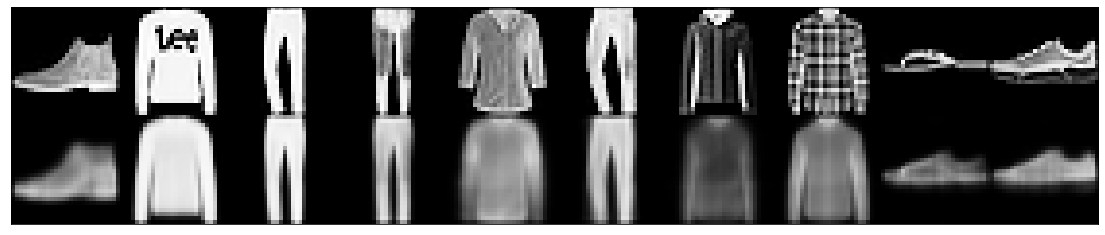

Epoch 97/100
60000/60000 [==============================] - 10s 166us/step - loss: 0.1644 - val_loss: 0.1597
Epoch 98/100
60000/60000 [==============================] - 10s 165us/step - loss: 0.1643 - val_loss: 0.1597
Epoch 99/100
60000/60000 [==============================] - 10s 165us/step - loss: 0.1643 - val_loss: 0.1597
Epoch 100/100
60000/60000 [==============================] - 10s 166us/step - loss: 0.1643 - val_loss: 0.1598


In [ ]:
# Запуск обучения 
vae.fit(x_train, x_train, shuffle=True, epochs=100,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        callbacks=[pltfig],
        verbose=1) # грузим наши данные в модель, задаем параметры и обучаем

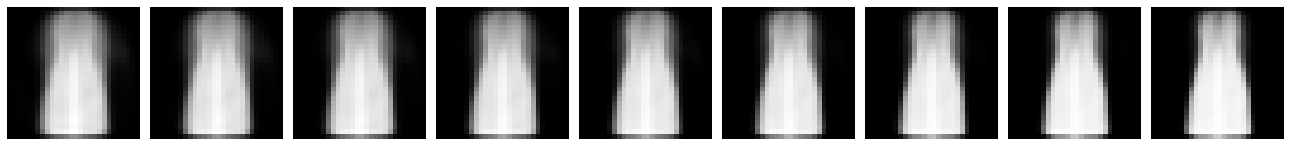

In [ ]:
plot_images(generator) # отрисовываем картинки 

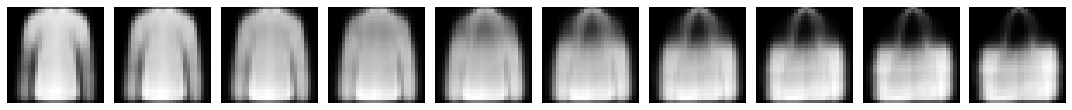

In [ ]:
plot_images_two_points(generator) # отрисовываем картинки 

#### Размер скрытого пространства = 20

In [ ]:
batch_size = 500 # размер батча
latent_dim = 20 # размер скрытого слоя/пространства
dropout_rate = 0.3 # размер слоя регуляризации, "выключим" указанное количество нейронов, во избежание переобучения
start_lr = 0.0001 # шаг обучения
img_shape = (28, 28, 1) # зармер картинки

models, vae_loss = create_vae() # получаем модели и свою функцию потерь
vae = models["vae"] # задаем модель вариационного автокодировщика

vae.compile(optimizer=Adam(start_lr), loss=vae_loss) # компилируем модель с выбранным оптимайзером и своей функцией потерь

digit_size = 28 # задаем размеры изобоажений

# Массивы, в которые будем сохранять результаты, для последующей визуализации
latent_distrs = []
epochs = []

# Эпохи, в которые будем сохранять
save_epochs = set([i*5 for i in range(0,25)])

imgs = x_test[:batch_size]
n_compare = 10

# Модели
generator      = models["decoder"]
encoder_mean   = models["z_meaner"]

# Коллбэки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)

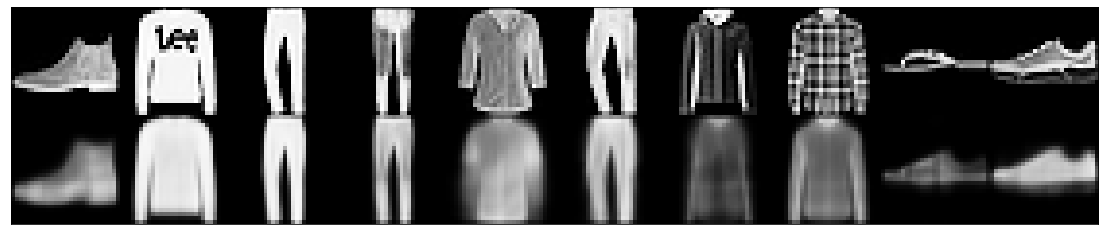

Epoch 97/100
60000/60000 [==============================] - 10s 165us/step - loss: 0.1644 - val_loss: 0.1598
Epoch 98/100
60000/60000 [==============================] - 10s 166us/step - loss: 0.1644 - val_loss: 0.1598
Epoch 99/100
60000/60000 [==============================] - 10s 166us/step - loss: 0.1643 - val_loss: 0.1598
Epoch 100/100
60000/60000 [==============================] - 10s 169us/step - loss: 0.1643 - val_loss: 0.1597


In [ ]:
# Запуск обучения 
vae.fit(x_train, x_train, shuffle=True, epochs=100,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        callbacks=[pltfig],
        verbose=1) # грузим наши данные в модель, задаем параметры и обучаем

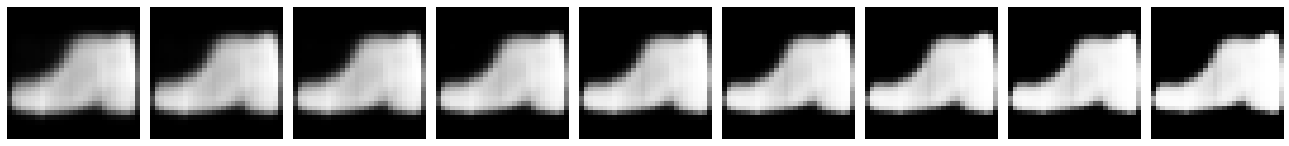

In [ ]:
plot_images(generator) # отрисовываем картинки 

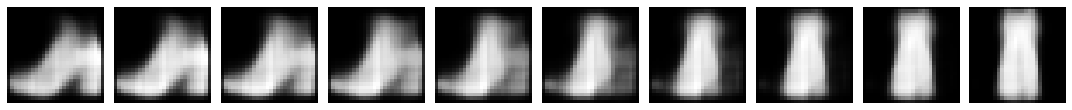

In [ ]:
plot_images_two_points(generator) # отрисовываем картинки 

#### Размер скрытого пространства = 100

In [ ]:
batch_size = 500 # размер батча
latent_dim = 100 # размер скрытого слоя/пространства
dropout_rate = 0.3 # размер слоя регуляризации, "выключим" указанное количество нейронов, во избежание переобучения
start_lr = 0.0001 # шаг обучения
img_shape = (28, 28, 1) # зармер картинки

models, vae_loss = create_vae() # получаем модели и свою функцию потерь
vae = models["vae"] # задаем модель вариационного автокодировщика

vae.compile(optimizer=Adam(start_lr), loss=vae_loss) # компилируем модель с выбранным оптимайзером и своей функцией потерь

digit_size = 28 # задаем размеры изобоажений

# Массивы, в которые будем сохранять результаты, для последующей визуализации
latent_distrs = []
epochs = []

# Эпохи, в которые будем сохранять
save_epochs = set([i*5 for i in range(0,25)])

imgs = x_test[:batch_size]
n_compare = 10

# Модели
generator      = models["decoder"]
encoder_mean   = models["z_meaner"]

# Коллбэки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)

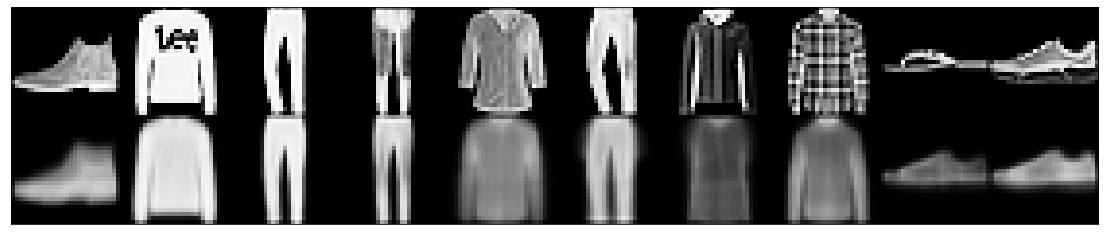

Epoch 97/100
60000/60000 [==============================] - 11s 188us/step - loss: 0.1653 - val_loss: 0.1608
Epoch 98/100
60000/60000 [==============================] - 11s 188us/step - loss: 0.1653 - val_loss: 0.1608
Epoch 99/100
60000/60000 [==============================] - 11s 189us/step - loss: 0.1652 - val_loss: 0.1608
Epoch 100/100
60000/60000 [==============================] - 11s 187us/step - loss: 0.1650 - val_loss: 0.1607


In [ ]:
# Запуск обучения 
vae.fit(x_train, x_train, shuffle=True, epochs=100,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        callbacks=[pltfig],
        verbose=1) # грузим наши данные в модель, задаем параметры и обучаем

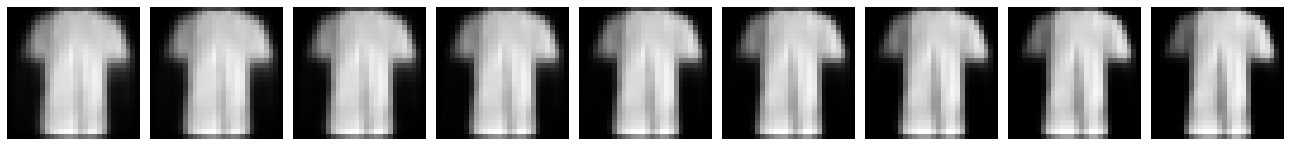

In [ ]:
plot_images(generator) # отрисовываем картинки 

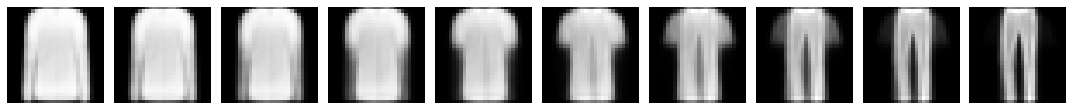

In [ ]:
plot_images_two_points(generator) # отрисовываем картинки 

#### Размер скрытого пространства = 200

In [ ]:
batch_size = 500 # размер батча
latent_dim = 200 # размер скрытого слоя/пространства
dropout_rate = 0.3 # размер слоя регуляризации, "выключим" указанное количество нейронов, во избежание переобучения
start_lr = 0.0001 # шаг обучения
img_shape = (28, 28, 1) # зармер картинки

models, vae_loss = create_vae() # получаем модели и свою функцию потерь
vae = models["vae"] # задаем модель вариационного автокодировщика

vae.compile(optimizer=Adam(start_lr), loss=vae_loss) # компилируем модель с выбранным оптимайзером и своей функцией потерь

digit_size = 28 # задаем размеры изобоажений

# Массивы, в которые будем сохранять результаты, для последующей визуализации
latent_distrs = []
epochs = []

# Эпохи, в которые будем сохранять
save_epochs = set([i*5 for i in range(0,25)])

imgs = x_test[:batch_size]
n_compare = 10

# Модели
generator      = models["decoder"]
encoder_mean   = models["z_meaner"]

# Коллбэки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)

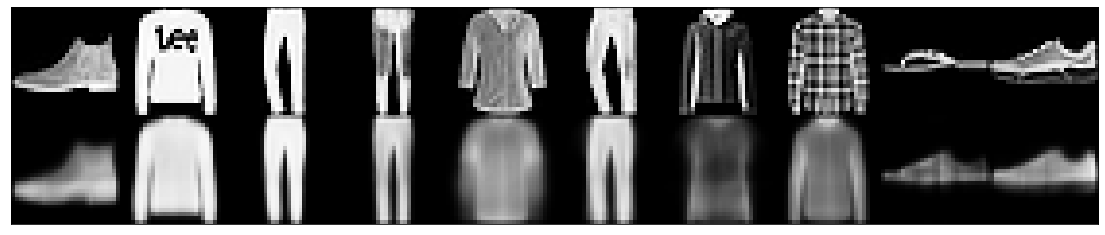

Epoch 97/100
60000/60000 [==============================] - 12s 203us/step - loss: 0.1657 - val_loss: 0.1614
Epoch 98/100
60000/60000 [==============================] - 12s 202us/step - loss: 0.1657 - val_loss: 0.1613
Epoch 99/100
60000/60000 [==============================] - 12s 201us/step - loss: 0.1656 - val_loss: 0.1612
Epoch 100/100
60000/60000 [==============================] - 12s 201us/step - loss: 0.1655 - val_loss: 0.1612


In [ ]:
# Запуск обучения 
vae.fit(x_train, x_train, shuffle=True, epochs=100,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        callbacks=[pltfig],
        verbose=1) # грузим наши данные в модель, задаем параметры и обучаем

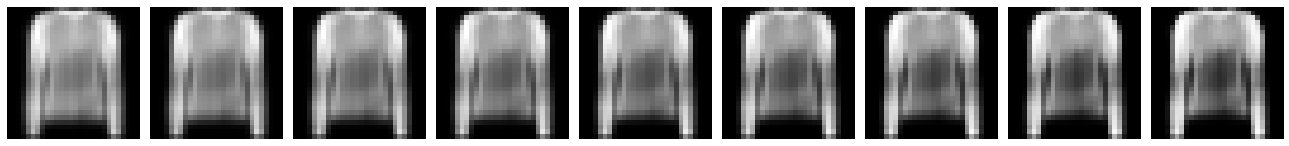

In [ ]:
plot_images(generator) # отрисовываем картинки 

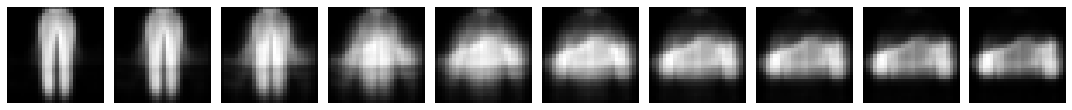

In [ ]:
plot_images_two_points(generator) # отрисовываем картинки 

#### **Итоги:**

loss: 0.1655 - val_loss: 0.1612  при размере скрытого пространства = 200

loss: 0.1650 - val_loss: 0.1607  при размере скрытого пространства = 100

loss: 0.1643 - val_loss: 0.1597 при размере скрытого пространства = 20

loss: 0.1643 - val_loss: 0.1598 при размере скрытого пространства = 10

Из этого можно сделать вывод что ошибка ниже при более маленьком размере скрытого пространства.
Если визуально посмотреть на результаты, то вывод такой же, самая высокая четкость у изоброжений при параметре размера скрытого пространства = 10. 

###2.  Сделайте свёрточный VAE, опишите разницу результатов с полносвязным

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import sys 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.stats import norm 
from keras.datasets import fashion_mnist 


from keras.optimizers import Adam, RMSprop 
from keras.layers import Input, Dense, Conv2D
from keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda, MaxPooling2D, UpSampling2D
from keras.models import Model 

from keras.objectives import binary_crossentropy 
from keras.layers.advanced_activations import LeakyReLU 
from keras import backend as K 
from IPython.display import clear_output 
from keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard 

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data() 

x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255. 
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) 
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1)) 

In [ ]:
# объявляем функцию создания вариационного автокодировщика

def create_vae(): 
    models = {} 

    # Энкодер
    input_img = Input(batch_shape=(batch_size, 28, 28, 1))
 
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(input_img)
    x = Dropout()(x)
    x = BatchNormalization()(x)  
    x = MaxPooling2D()(x)

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Dropout()(x)
    x = BatchNormalization()(x) 
    x = MaxPooling2D()(x) 
    x = Flatten()(x)
    # Предсказываем параметры распределений
    # Вместо того, чтобы предсказывать стандартное отклонение, предсказываем логарифм вариации
    
    z_mean = Dense(latent_dim)(x) # скрытое пространство(мат.ожидание) размером 10
    
    z_log_var = Dense(latent_dim)(x) # скрытое пространство(лог.вариации) размером 10

    # Сэмплирование из Q с трюком репараметризации
    def sampling(args): # обьявляем функцию сэмплирования
        z_mean, z_log_var = args # принимаем в аргументах z_mean, z_log_var, раскусываем их
        
        # Керасовским методом делаем нормальное распределение(500 10тимерных), мат.ожидание 0, ст.отклонение 1
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # Задаем самописный слой, к-й принимает лист [z_mean, z_log_var], семплирует, и на выходе выдает размерность (10,)
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    models["encoder"]  = Model(input_img, l) # модель энкодера от входа до лямбда слоя
    
    models["z_meaner"] = Model(input_img, z_mean) # отдельная модель с путем от входа до z_mean
    
    models["z_lvarer"] = Model(input_img, z_log_var) # отдельная модель с путем от входа до z_log_var

    # Декодер
    z = Input(shape=(latent_dim, )) 
    x = Dense(49)(z)
    x = Reshape((7, 7, 1))(x) 
    x = Conv2D(32, (7, 7), activation='relu', padding='same')(x)
    x = Dropout()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (2, 2), activation='relu', padding='same')(x)
    x = Dropout()(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (7, 7), activation='sigmoid', padding='same')(x)

    models["decoder"] = Model(z, decoded) # собираем модель декодера
    
    # Cобираем вариационный автокодировщик, также двойное преобразование над входной картинкой(энкодер-декодер)
    models["vae"] = Model(input_img, models["decoder"](models["encoder"](input_img)))

    # объявляем самописную функцию потерь
    def vae_loss(x, decoded): 
        x = K.reshape(x, shape=(batch_size, 28*28)) 
        decoded = K.reshape(decoded, shape=(batch_size, 28*28)) 
        xent_loss = 28*28*binary_crossentropy(x, decoded) 
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
        return (xent_loss + kl_loss)/2/28/28 # функция вернет суммарную ошибку с учетом распределения и размеров пикселей

    return models, vae_loss

In [ ]:
# функция отрисует две линии картинок - оригинальные и выходные из автокодировщика
def plot_digits(*args, invert_colors=False): 
    args = [x.squeeze() for x in args]  
    n = min([x.shape[0] for x in args])
    figure = np.zeros((digit_size * len(args), digit_size * n)) 

    for i in range(n):
        for j in range(len(args)): # заполняем фигуру значениями
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    if invert_colors: # если значение invert_colors будет True
        figure = 1-figure # то фигуру делаем обратной

    plt.figure(figsize=(2*n, 2*len(args))) 
    plt.imshow(figure, cmap='Greys_r') # выведем ее на экран в указанных цветах
    plt.grid(False) 
    ax = plt.gca() 
    ax.get_xaxis().set_visible(False) 
    ax.get_yaxis().set_visible(False) 
    plt.show() # выводим отрисованное на экран

In [ ]:
# Функция, которую будем запускать после каждой эпохи
def on_epoch_end(epoch, logs):
    if epoch in save_epochs:
        clear_output() # Не захламляем output

        # Сравнение реальных и декодированных изображений
        decoded = vae.predict(imgs, batch_size=batch_size)
        plot_digits(imgs[:n_compare], decoded[:n_compare])

        # Сохранение многообразия и распределения z для создания анимации после
        epochs.append(epoch)
        latent_distrs.append(encoder_mean.predict(x_test, batch_size))

In [ ]:
digit_size = 28 # задаем размеры изобоажений

def plot_images(generator, examples=9, dim=(10,10), figsize=(20,20)): # функция добавляет шум на скрытом пространстве
    k = 1.1
    noise = np.random.normal(loc=0, scale=1, size=[1, latent_dim]) # создаем шум нормальным распределением
    
    im_arr = [generator.predict((k**i)*noise) for i in range(0,examples)] # получаем сгенеренные выходные картинки над заданным шумом
    im_arr = np.array(im_arr).reshape(examples,28,28) 

    plt.figure(figsize=figsize) # задаем способ отрисовки картинок
    for i in range(im_arr.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(im_arr[i], interpolation='nearest')
        plt.axis('off')
        plt.gray()
    plt.tight_layout()

In [ ]:
def plot_images_two_points(generator, examples=10, dim=(10,10), figsize=(15,15)):
    
    noise1 = 1*np.random.normal(loc=0, scale=1, size=[1, latent_dim]) # создаем первое случайное зашумленное распределение
    noise2 = 1*np.random.normal(loc=0, scale=1, size=[1, latent_dim]) # создаем второе случайное зашумленное распределение
    
    # получаем сгенеренные выходные картинки плавным переходом от одного зашумленного к другому 
    im_arr = [generator.predict(i*noise2/(examples-1) + (examples-i-1)*noise1/(examples-1)) for i in range(0,examples)]
    im_arr = np.array(im_arr).reshape(examples,28,28) 

    plt.figure(figsize=figsize) # задаем способ отрисовки картинок
    for i in range(im_arr.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(im_arr[i], interpolation='nearest', )
        plt.axis('off')
    plt.tight_layout()

In [ ]:
def plot_images_two_points2(generator, z_imgs, examples=10, dim=(10,10), figsize=(15,15)):
    
    index1 = int(round(200*np.random.sample(1)[0])) # запишем в первый индекс случайно сгенерированное значение
    index2 = int(round(200*np.random.sample(1)[0])) # запишем во второй индекс случайно сгенерированное значение
    noise1 = z_imgs[index1,:].reshape(1,10) # сгенерируем первую зашумленную картинку по полученному индексу
    noise2 = z_imgs[index2,:].reshape(1,10) # сгенерируем вторую зашумленную картинку по полученному индексу
    
    # получаем сгенеренные выходные картинки плавным переходом от одного зашумленного к другому 
    im_arr = [generator.predict(i*noise2/(examples-1) + (examples-i-1)*noise1/(examples-1)) for i in range(0,examples)]
    im_arr = np.array(im_arr).reshape(examples,28,28) 

    plt.figure(figsize=figsize) # задаем способ отрисовки картинок
    for i in range(im_arr.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(im_arr[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()

In [ ]:
batch_size = 500 # размер батча
latent_dim = 10 # размер скрытого слоя/пространства
dropout_rate = 0.3 # размер слоя регуляризации, "выключим" указанное количество нейронов, во избежание переобучения
start_lr = 0.0001 # шаг обучения
img_shape = (28, 28, 1) # зармер картинки

models, vae_loss = create_vae() # получаем модели и свою функцию потерь
vae = models["vae"] # задаем модель вариационного автокодировщика

vae.compile(optimizer=Adam(start_lr), loss=vae_loss) # компилируем модель с выбранным оптимайзером и своей функцией потерь

digit_size = 28 # задаем размеры изобоажений

# Массивы, в которые будем сохранять результаты, для последующей визуализации
latent_distrs = []
epochs = []

# Эпохи, в которые будем сохранять
save_epochs = set([i*5 for i in range(0,25)])

imgs = x_test[:batch_size]
n_compare = 10

# Модели
generator      = models["decoder"]
encoder_mean   = models["z_meaner"]

# Коллбэки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)

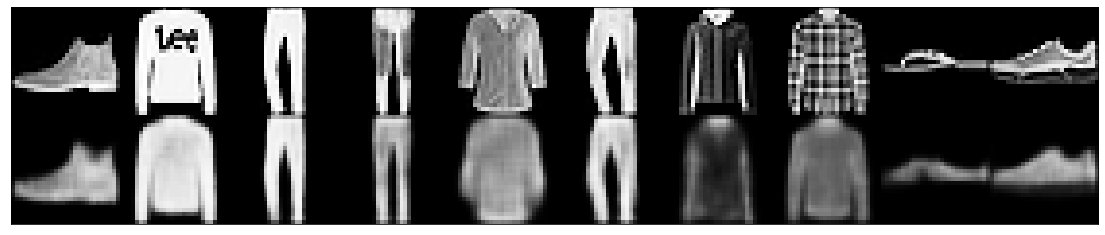

Epoch 97/100
60000/60000 [==============================] - 11s 189us/step - loss: 0.1575 - val_loss: 0.1586
Epoch 98/100
60000/60000 [==============================] - 11s 189us/step - loss: 0.1574 - val_loss: 0.1587
Epoch 99/100
60000/60000 [==============================] - 11s 189us/step - loss: 0.1574 - val_loss: 0.1586
Epoch 100/100
60000/60000 [==============================] - 11s 189us/step - loss: 0.1574 - val_loss: 0.1589


In [ ]:
# Запуск обучения 
vae.fit(x_train, x_train, shuffle=True, epochs=100,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        callbacks=[pltfig],
        verbose=1) # грузим наши данные в модель, задаем параметры и обучаем

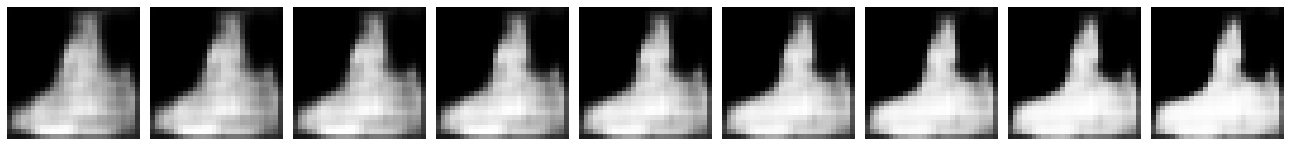

In [ ]:
plot_images(generator) # отрисовываем картинки 

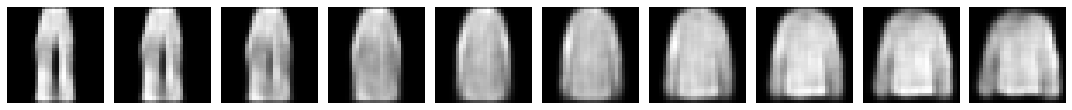

In [ ]:
plot_images_two_points(generator) # отрисовываем картинки 

**Итоги:**

при:

* batch_size = 500 # размер батча

* latent_dim = 10 # размер скрытого слоя/пространства

* dropout_rate = 0.3 # размер слоя регуляризации

* start_lr = 0.0001 # шаг обучения

результаты:

loss: 0.1643 - val_loss: 0.1598 при полносвязной сети

loss: 0.1574 - val_loss: 0.1589 при светрочной сети

Визуально работа сверточной и полносвязной сети не сильно отличаются, но всеже при сверточном VAE изображения получаются более четкими и детально прорисованными, а также размер ошибки при сверточном VAE меньше. Из этого можно сделать вывод, что доработав сверточный VAE можно добиться очень хороших результатов и еще более четких картинок, чем при полносвязном VAE.




### 3. Сделайте более мощный CVAE, обучите больше эпох до более низкого уровня ошибки и сравните изображения, которые получаются в итоге, коррелирует ли уровень ошибки с качеством изображений



In [ ]:
!pip install keras==2.0 -q # загружаем эту версию кераса для корректной работы скрипта
!pip install tensorflow==1.0 -q  # загружаем эту версию тензорфлоу  для корректной работы скрипта

     |████████████████████████████████| 194kB 8.2MB/s 
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.0.0 which is incompatible.
     |████████████████████████████████| 44.5MB 68kB/s 


In [ ]:
import sys # модуль содержит параметры и функции, которые относятся к Python и его среде
import numpy as np # загружаем библиотеку для работы с массивами данных
import matplotlib.pyplot as plt # из библиотеки для визуализации данных возьмём интерфейс для построения графиков простых функций
%matplotlib inline
from scipy.stats import norm # модуль с нормальными непрерывными случайными величинами
# import seaborn as sns

from keras.datasets import mnist # загружаем готовую стандартную базу рукописных цифр mnist
from keras.utils import to_categorical # загружаем утилиты кераса для one-hot кодировки
from keras.layers import Input, Dense # загружаем необходимые слои(входной, полносвязный)
from keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda # загружаем слои(нормализации, регуляризации и т.д)
from keras.layers import concatenate # подгружаем слой конкатенации
from keras.models import Model # загружаем абстрактный класс базовой модели сети от кераса 
from keras.objectives import binary_crossentropy # импортируем функцию потерь
from keras.layers.advanced_activations import LeakyReLU # импортируем функцию активации
from keras import backend as K # устанавливаем переменную для окружения кераса
from keras.optimizers import Adam, RMSprop # загружаем выбранные оптимизаторы
from IPython.display import clear_output # импортируем модуль очистки output'а ячейки
from keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard # импортируем коллбэки

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:472: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:473: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:474: FutureWarn

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data() 

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data() # загружаем данные из базы mnist с разбивкой на train/test
#(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255. # представляем x_train в виде значений от 0 до 1
x_test  = x_test .astype('float32') / 255. # представляем x_test в виде значений от 0 до 1
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) # меняем форму, приводим к нужным нам размерам
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1)) # меняем форму, приводим к нужным нам размерам

y_train_cat = to_categorical(y_train).astype(np.float32) # переводим обучающие лейблы в one-hot кодировку
y_test_cat  = to_categorical(y_test).astype(np.float32) # переводим проверочные лейблы в one-hot кодировку
num_classes = y_test_cat.shape[1] # задаем количество классов

In [ ]:
batch_size = 500 # размер батча
latent_dim = 200 # размер скрытого слоя/пространства
dropout_rate = 0.3 # размер слоя регуляризации, "выключим" указанное количество нейронов, во избежание переобучения
start_lr = 0.001 # шаг обучения

In [ ]:
def create_cvae(): # объявляем функцию создания вариационного автокодировщика c условием
    models = {} # задаем словарь моделей

    # Добавим Dropout и BatchNormalization
    def apply_bn_and_dropout(x): # функция будет принимать на вход слой x
        return Dropout(dropout_rate)(BatchNormalization()(x)) # и применять к нему регуляризацию/нормализацию

    # Энкодер
    input_img = Input(shape=(28, 28, 1)) # размерности строк, столбцов, фильтров одной картинки
    flatten_img = Flatten()(input_img) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
    input_lbl = Input(shape=(num_classes,), dtype='float32') # второй вход в энкодер с учетом лейблов и по количеству классов

    x = concatenate([flatten_img, input_lbl]) # конкатенируем входы сглаженной входной картинки и input_lbl
    
    x = Dense(512, activation='relu')(x) # полносвязный слой на 256 нейронов
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    x = Dense(512, activation='relu')(x) # полносвязный слой на 256 нейронов
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    x = Dense(512, activation='relu')(x) # полносвязный слой на 256 нейронов
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    x = Dense(512, activation='relu')(x) # полносвязный слой на 256 нейронов
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    
    # Предсказываем параметры распределений
    
    # Вместо того чтобы предсказывать стандартное отклонение, предсказываем логарифм вариации
    z_mean = Dense(latent_dim)(x) # скрытое пространство(мат.ожидание) размером 8
    z_log_var = Dense(latent_dim)(x) # скрытое пространство(лог.вариации) размером 8

    # Сэмплирование из Q с трюком репараметризации
    def sampling(args): # обьявляем функцию сэмплирования
        z_mean, z_log_var = args # принимаем в аргументах z_mean, z_log_var, раскусываем их
        # керасовским методом делаем нормальное распределение(500 8мерных), мат.ожидание 0, ст.отклонение 1
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # задаем самописный слой, к-й принимает лист [z_mean, z_log_var], семплирует, и на выходе выдает размерность (8,)
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var]) 

    models["encoder"]  = Model([input_img, input_lbl], l) # модель энкодера от входов до лямбда слоя
    models["z_meaner"] = Model([input_img, input_lbl], z_mean) # отдельная модель с путем от входов до z_mean
    models["z_lvarer"] = Model([input_img, input_lbl], z_log_var) # отдельная модель с путем от входов до z_log_var

    # Декодер
    z = Input(shape=(latent_dim, )) # задаем первую входную размерность (8,)
    input_lbl_d = Input(shape=(num_classes,), dtype='float32') # задаем вторую входную размерность по номеру классов
    x = concatenate([z, input_lbl_d]) # конкатенируем входы
    x = Dense(512)(x) # полносвязный слой на 256 нейронов
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    x = Dense(512)(x) # полносвязный слой на 256 нейронов
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    x = Dense(512)(x) # полносвязный слой на 256 нейронов
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    x = Dense(512)(x) # полносвязный слой на 256 нейронов
    x = LeakyReLU()(x) # применяем функцию активации отдельным слоем
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    x = Dense(28*28, activation='sigmoid')(x) # полносвязный слой на 784 нейрона
    decoded = Reshape((28, 28, 1))(x) # меняем форму, приводим к нужным нам размерам

    models["decoder"] = Model([z, input_lbl_d], decoded) # собираем модель декодера
    
    # Cобираем вариационный автокодировщик с условием(3 инпута на входе, затем первые два проходят через энкодер,
    # складываются с input_lbl_d и всё это проходит через декодер на выходе)
    models["cvae"]    = Model([input_img, input_lbl, input_lbl_d], 
                              models["decoder"]([models["encoder"]([input_img, input_lbl]), input_lbl_d]), 
                              name="CVAE")
    # Та же операция, но вместо энкодера модель z_meaner
    models["style_t"] = Model( [input_img, input_lbl, input_lbl_d] , 
                               models["decoder"] ( [models["z_meaner"]([input_img, input_lbl]), input_lbl_d] ) , 
                               name="style_transfer")
    
    
    def vae_loss(x, decoded): # объявляем самописную функцию потерь
        x = K.reshape(x, shape=(batch_size, 28*28)) # меняем размеры(в одномерный) x через керасовскую функцию
        decoded = K.reshape(decoded, shape=(batch_size, 28*28)) # меняем размеры(в одномерный) decoded через керасовскую функцию
        xent_loss = 28*28*binary_crossentropy(x, decoded) # берем бинарную кроссэнтропию между x и decoded, с учетом пикселей
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) # по формуле устанавливаем ошибку kl_loss
        return (xent_loss + kl_loss)/2/28/28 # функция вернет суммарную ошибку с учетом распределения и размеров пикселей

    return models, vae_loss

models, vae_loss = create_cvae() # получаем модели и свою функцию потерь
cvae = models["cvae"] # задаем модель вариационного автокодировщика с условием

In [ ]:
cvae.compile(optimizer = Adam(start_lr), loss=vae_loss) # компилируем модель с выбранным оптимайзером и своей функцией потерь

In [ ]:
digit_size = 28 # задаем размеры цифр
def plot_digits(*args, invert_colors=False): # функция отрисует две линии картинок - оригинальные и выходные из автокодировщика
    args = [x.squeeze() for x in args] # удаляем оси с одним элементом из аргументов
    n = min([x.shape[0] for x in args]) # берем минимальное от нулевой оси x'ов в аргументах
    figure = np.zeros((digit_size * len(args), digit_size * n)) # создаем фигуру с использованием массива нулей по заданным размерам

    for i in range(n):
        for j in range(len(args)): # заполняем фигуру значениями
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    if invert_colors: # если значение invert_colors будет True
        figure = 1-figure # то фигуру делаем обратной

    plt.figure(figsize=(2*n, 2*len(args))) # плотим фигуру с заданными значениями
    plt.imshow(figure, cmap='Greys_r') # выведем ее на экран в указанных цветах
    plt.grid(False) # указываем, что сетка не нужна
    ax = plt.gca() # получаем текущий объект Axes
    ax.get_xaxis().set_visible(False) # ось координат xaxis делаем невидимой
    ax.get_yaxis().set_visible(False) # ось координат yaxis делаем невидимой
    plt.show() # выводим отрисованное на экран


n = 15 # Картинка с 15x15 цифр


In [ ]:
# Эпохи, в которые будем сохранять
save_epochs = set([i*5 for i in range(0,25)])

# Отслеживать будем на вот этих цифрах
imgs = x_test[:batch_size]
imgs_lbls = y_test_cat[:batch_size]
n_compare = 10

# Модели
generator      = models["decoder"]
encoder_mean   = models["z_meaner"]


# Функция, которую будем запускать после каждой эпохи
def on_epoch_end(epoch, logs):
    if epoch in save_epochs:
        clear_output() # Не захламляем output

        # Сравнение реальных и декодированных цифр
        decoded = cvae.predict([imgs, imgs_lbls, imgs_lbls], batch_size=batch_size)
        plot_digits(imgs[:n_compare], decoded[:n_compare])



# Коллбэки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)
# lr_red = ReduceLROnPlateau(factor=0.1, patience=25)
tb     = TensorBoard(log_dir='./logs')

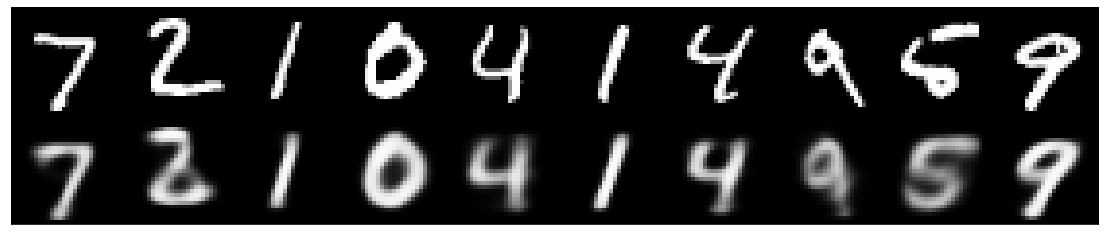

60000/60000 [==============================] - 46s - loss: 0.0898 - val_loss: 0.0807
Epoch 17/20
60000/60000 [==============================] - 46s - loss: 0.0896 - val_loss: 0.0806
Epoch 18/20
60000/60000 [==============================] - 46s - loss: 0.0895 - val_loss: 0.0805
Epoch 19/20
60000/60000 [==============================] - 46s - loss: 0.0894 - val_loss: 0.0803
Epoch 20/20
60000/60000 [==============================] - 46s - loss: 0.0893 - val_loss: 0.0804


In [ ]:
# Запуск обучения 
cvae.fit([x_train, y_train_cat, y_train_cat], x_train, shuffle=True, epochs=20,
         batch_size=batch_size,
         validation_data=([x_test, y_test_cat, y_test_cat], x_test),
         callbacks=[pltfig, tb],
         verbose=1) # грузим наши данные в модель, задаем параметры и обучаем

In [ ]:
def style_transfer(model, X, lbl_in, lbl_out): # объявляем функцию переноса стилей
    rows = X.shape[0] 
    if isinstance(lbl_in, int): # заполняем входные лейблы(энкодера)
        lbl = lbl_in 
        lbl_in = np.zeros((rows, 10)) # построчное заполнение нулями от 0 до 9
        lbl_in[:, lbl] = 1 # заполняем в нужную строчку единицу
    if isinstance(lbl_out, int): # заполняем выходные лейблы(декодера)
        lbl = lbl_out
        lbl_out = np.zeros((rows, 10)) # построчное заполнение нулями от 0 до 9
        lbl_out[:, lbl] = 1 # заполняем в нужную строчку единицу
    #print(lbl_in)
    #print(lbl_out)
    return model.predict([X, lbl_in, lbl_out]) # функция вернет предсказанные картинки

Сравним с результатом на 200 эпохах обучения

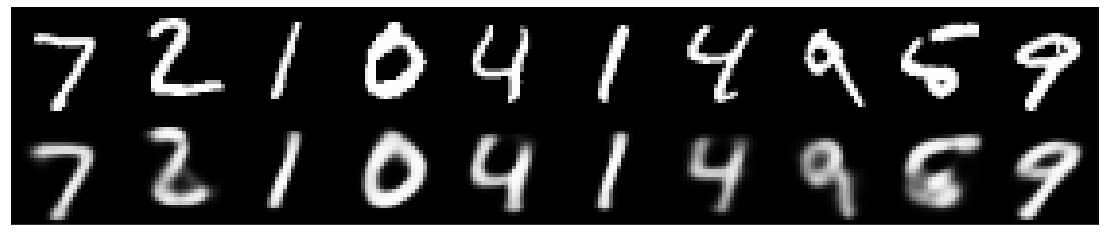

60000/60000 [==============================] - 102s - loss: 0.0812 - val_loss: 0.0731
Epoch 47/50
60000/60000 [==============================] - 102s - loss: 0.0812 - val_loss: 0.0728
Epoch 48/50
60000/60000 [==============================] - 104s - loss: 0.0811 - val_loss: 0.0728
Epoch 49/50
60000/60000 [==============================] - 106s - loss: 0.0812 - val_loss: 0.0729
Epoch 50/50
60000/60000 [==============================] - 107s - loss: 0.0811 - val_loss: 0.0728


In [ ]:
# Запуск обучения 
cvae.fit([x_train, y_train_cat, y_train_cat], x_train, shuffle=True, epochs=50,
         batch_size=batch_size,
         validation_data=([x_test, y_test_cat, y_test_cat], x_test),
         callbacks=[pltfig, tb],
         verbose=1) # грузим наши данные в модель, задаем параметры и обучаем

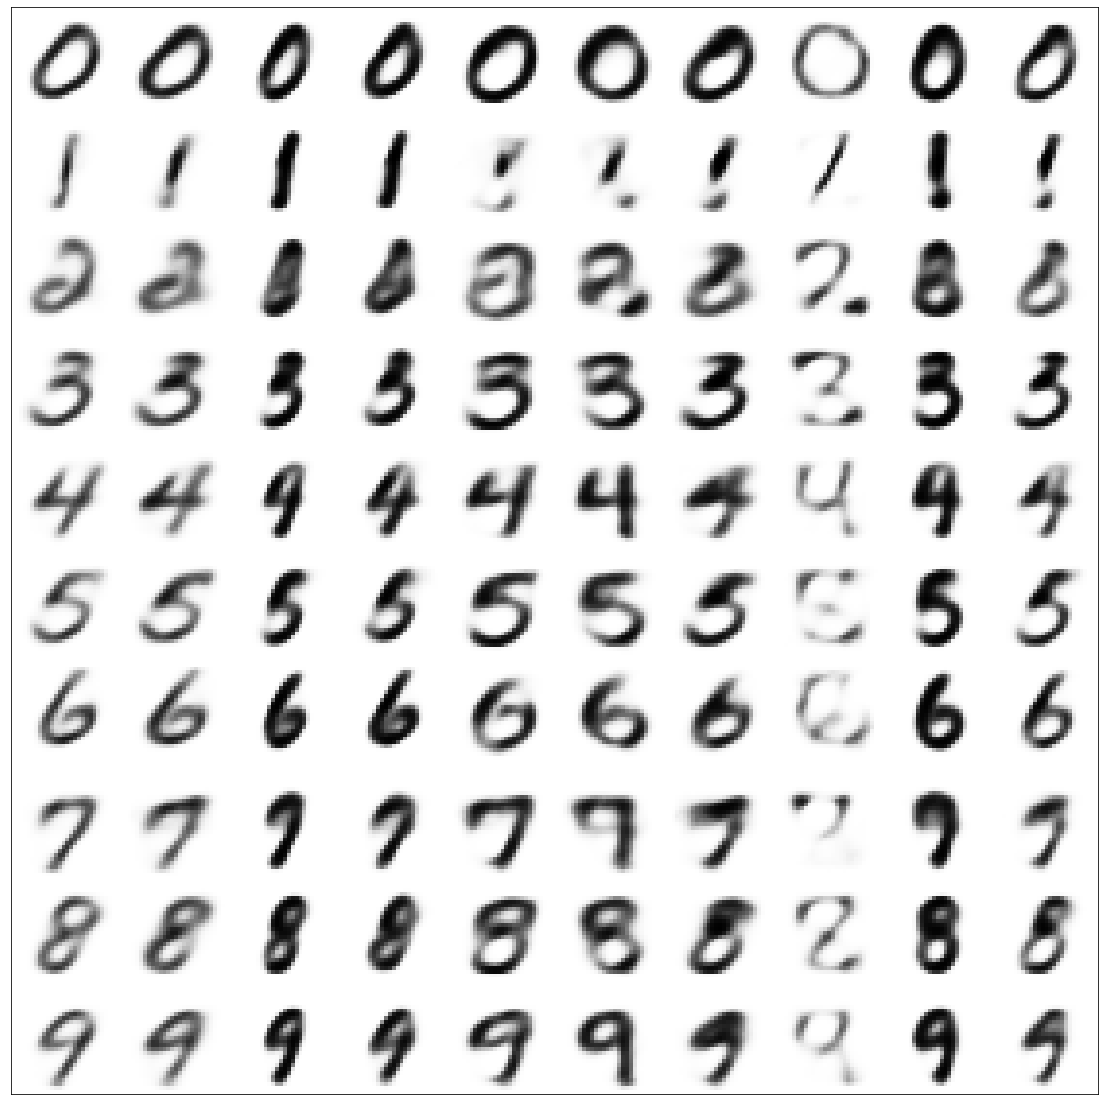

In [ ]:
n = 10 # выбираем количество картинок
lbl = 0 # выбираем лейбл
generated = [] # здесь соберем список сгенерированных картинок
prot = x_train[y_train == lbl][:n] # возьмем prot в качестве x с соответствующим выбранному значению лейбла 

for i in range(num_classes): # идем по каждому классу
    generated.append(style_transfer(models["style_t"], prot, lbl, i)) # и генерим картинки с учетом переноса стиля

#generated[lbl] = prot
plot_digits(*generated, invert_colors=True) # отрисовываем картинки

**Итоги:**

Из полученных результатов (сделав CVAE более мощным и обучив больше эпох) можно сделать вывод, что уровень ошибки коррелируется с качеством изображений, так как при более низком уровне ошибки результат оказался лучше(картинки более четкие и детальнее прорисованные), чем при более высоком уровне ошибки.

### 4. Подайте 5 раз в decoder CVAE один и тот же случайный вектор и label любой от 0 до 9 на выбор, посмотрите, что сгенерирует CVAE

In [ ]:
!pip install keras==2.0 -q # загружаем эту версию кераса для корректной работы скрипта
!pip install tensorflow==1.0 -q  # загружаем эту версию тензорфлоу  для корректной работы скрипта

     |████████████████████████████████| 194kB 2.8MB/s 
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.0.0 which is incompatible.
     |████████████████████████████████| 44.5MB 90kB/s 


In [ ]:
import sys # модуль содержит параметры и функции, которые относятся к Python и его среде
import numpy as np # загружаем библиотеку для работы с массивами данных
import matplotlib.pyplot as plt # из библиотеки для визуализации данных возьмём интерфейс для построения графиков простых функций
%matplotlib inline
from scipy.stats import norm # модуль с нормальными непрерывными случайными величинами
# import seaborn as sns

from keras.datasets import mnist # загружаем готовую стандартную базу рукописных цифр mnist
from keras.utils import to_categorical # загружаем утилиты кераса для one-hot кодировки
from keras.layers import Input, Dense # загружаем необходимые слои(входной, полносвязный)
from keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda # загружаем слои(нормализации, регуляризации и т.д)
from keras.layers import concatenate # подгружаем слой конкатенации
from keras.models import Model # загружаем абстрактный класс базовой модели сети от кераса 
from keras.objectives import binary_crossentropy # импортируем функцию потерь
from keras.layers.advanced_activations import LeakyReLU # импортируем функцию активации
from keras import backend as K # устанавливаем переменную для окружения кераса
from keras.optimizers import Adam, RMSprop # загружаем выбранные оптимизаторы
from IPython.display import clear_output # импортируем модуль очистки output'а ячейки
from keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard # импортируем коллбэки

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:472: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:473: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:474: FutureWarn

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data() 

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data() # загружаем данные из базы mnist с разбивкой на train/test
#(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255. # представляем x_train в виде значений от 0 до 1
x_test  = x_test .astype('float32') / 255. # представляем x_test в виде значений от 0 до 1
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) # меняем форму, приводим к нужным нам размерам
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1)) # меняем форму, приводим к нужным нам размерам

y_train_cat = to_categorical(y_train).astype(np.float32) # переводим обучающие лейблы в one-hot кодировку
y_test_cat  = to_categorical(y_test).astype(np.float32) # переводим проверочные лейблы в one-hot кодировку
num_classes = y_test_cat.shape[1] # задаем количество классов

In [ ]:
batch_size = 500 # размер батча
latent_dim = 200 # размер скрытого слоя/пространства
dropout_rate = 0.3 # размер слоя регуляризации, "выключим" указанное количество нейронов, во избежание переобучения
start_lr = 0.001 # шаг обучения

In [ ]:
def create_cvae(): # объявляем функцию создания вариационного автокодировщика c условием
    models = {} # задаем словарь моделей

    # Добавим Dropout и BatchNormalization
    def apply_bn_and_dropout(x): # функция будет принимать на вход слой x
        return Dropout(dropout_rate)(BatchNormalization()(x)) # и применять к нему регуляризацию/нормализацию

    # Энкодер
    input_img = Input(shape=(28, 28, 1)) # размерности строк, столбцов, фильтров одной картинки
    flatten_img = Flatten()(input_img) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
    input_lbl = Input(shape=(num_classes,), dtype='float32') # второй вход в энкодер с учетом лейблов и по количеству классов

    x = concatenate([flatten_img, input_lbl]) # конкатенируем входы сглаженной входной картинки и input_lbl
    
    x = Dense(128, activation='relu')(x) # полносвязный слой на 256 нейронов
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    x = Dense(128, activation='relu')(x) # полносвязный слой на 256 нейронов
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
        
    # Предсказываем параметры распределений
    
    # Вместо того чтобы предсказывать стандартное отклонение, предсказываем логарифм вариации
    z_mean = Dense(latent_dim)(x) # скрытое пространство(мат.ожидание) размером 8
    z_log_var = Dense(latent_dim)(x) # скрытое пространство(лог.вариации) размером 8

    # Сэмплирование из Q с трюком репараметризации
    def sampling(args): # обьявляем функцию сэмплирования
        z_mean, z_log_var = args # принимаем в аргументах z_mean, z_log_var, раскусываем их
        # керасовским методом делаем нормальное распределение(500 8мерных), мат.ожидание 0, ст.отклонение 1
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # задаем самописный слой, к-й принимает лист [z_mean, z_log_var], семплирует, и на выходе выдает размерность (8,)
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var]) 

    models["encoder"]  = Model([input_img, input_lbl], l) # модель энкодера от входов до лямбда слоя
    models["z_meaner"] = Model([input_img, input_lbl], z_mean) # отдельная модель с путем от входов до z_mean
    models["z_lvarer"] = Model([input_img, input_lbl], z_log_var) # отдельная модель с путем от входов до z_log_var

    # Декодер
    z = Input(shape=(latent_dim, )) # задаем первую входную размерность (8,)
    input_lbl_d = Input(shape=(num_classes,), dtype='float32') # задаем вторую входную размерность по номеру классов
    x = concatenate([z, input_lbl_d]) # конкатенируем входы
    x = Dense(128)(x) # полносвязный слой на 256 нейронов
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    x = Dense(128)(x) # полносвязный слой на 256 нейронов
    x = LeakyReLU()(x) # применяем функцию активации отдельным слоем
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    x = Dense(28*28, activation='sigmoid')(x) # полносвязный слой на 784 нейрона
    decoded = Reshape((28, 28, 1))(x) # меняем форму, приводим к нужным нам размерам

    models["decoder"] = Model([z, input_lbl_d], decoded) # собираем модель декодера
    
    # Cобираем вариационный автокодировщик с условием(3 инпута на входе, затем первые два проходят через энкодер,
    # складываются с input_lbl_d и всё это проходит через декодер на выходе)
    models["cvae"]    = Model([input_img, input_lbl, input_lbl_d], 
                              models["decoder"]([models["encoder"]([input_img, input_lbl]), input_lbl_d]), 
                              name="CVAE")
    # Та же операция, но вместо энкодера модель z_meaner
    models["style_t"] = Model( [input_img, input_lbl, input_lbl_d] , 
                               models["decoder"] ( [models["z_meaner"]([input_img, input_lbl]), input_lbl_d] ) , 
                               name="style_transfer")
    
    
    def vae_loss(x, decoded): # объявляем самописную функцию потерь
        x = K.reshape(x, shape=(batch_size, 28*28)) # меняем размеры(в одномерный) x через керасовскую функцию
        decoded = K.reshape(decoded, shape=(batch_size, 28*28)) # меняем размеры(в одномерный) decoded через керасовскую функцию
        xent_loss = 28*28*binary_crossentropy(x, decoded) # берем бинарную кроссэнтропию между x и decoded, с учетом пикселей
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) # по формуле устанавливаем ошибку kl_loss
        return (xent_loss + kl_loss)/2/28/28 # функция вернет суммарную ошибку с учетом распределения и размеров пикселей

    return models, vae_loss

models, vae_loss = create_cvae() # получаем модели и свою функцию потерь
cvae = models["cvae"] # задаем модель вариационного автокодировщика с условием

In [ ]:
cvae.compile(optimizer = Adam(start_lr), loss=vae_loss) # компилируем модель с выбранным оптимайзером и своей функцией потерь

In [ ]:
digit_size = 28 # задаем размеры цифр
def plot_digits(*args, invert_colors=False): # функция отрисует две линии картинок - оригинальные и выходные из автокодировщика
    args = [x.squeeze() for x in args] # удаляем оси с одним элементом из аргументов
    n = min([x.shape[0] for x in args]) # берем минимальное от нулевой оси x'ов в аргументах
    figure = np.zeros((digit_size * len(args), digit_size * n)) # создаем фигуру с использованием массива нулей по заданным размерам

    for i in range(n):
        for j in range(len(args)): # заполняем фигуру значениями
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    if invert_colors: # если значение invert_colors будет True
        figure = 1-figure # то фигуру делаем обратной

    plt.figure(figsize=(2*n, 2*len(args))) # плотим фигуру с заданными значениями
    plt.imshow(figure, cmap='Greys_r') # выведем ее на экран в указанных цветах
    plt.grid(False) # указываем, что сетка не нужна
    ax = plt.gca() # получаем текущий объект Axes
    ax.get_xaxis().set_visible(False) # ось координат xaxis делаем невидимой
    ax.get_yaxis().set_visible(False) # ось координат yaxis делаем невидимой
    plt.show() # выводим отрисованное на экран


n = 15 # Картинка с 15x15 цифр


In [ ]:
# Эпохи, в которые будем сохранять
save_epochs = set([i*5 for i in range(0,25)])

# Отслеживать будем на вот этих цифрах
imgs = x_test[:batch_size]
imgs_lbls = y_test_cat[:batch_size]
n_compare = 10

# Модели
generator      = models["decoder"]
encoder_mean   = models["z_meaner"]


# Функция, которую будем запускать после каждой эпохи
def on_epoch_end(epoch, logs):
    if epoch in save_epochs:
        clear_output() # Не захламляем output

        # Сравнение реальных и декодированных цифр
        decoded = cvae.predict([imgs, imgs_lbls, imgs_lbls], batch_size=batch_size)
        plot_digits(imgs[:n_compare], decoded[:n_compare])



# Коллбэки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)
# lr_red = ReduceLROnPlateau(factor=0.1, patience=25)
tb     = TensorBoard(log_dir='./logs')

In [ ]:
def style_transfer(model, X, lbl_in, lbl_out): # объявляем функцию переноса стилей
    rows = X.shape[0] 
    if isinstance(lbl_in, int): # заполняем входные лейблы(энкодера)
        lbl = lbl_in 
        lbl_in = np.zeros((rows, 10)) # построчное заполнение нулями от 0 до 9
        lbl_in[:, lbl] = 1 # заполняем в нужную строчку единицу
    if isinstance(lbl_out, int): # заполняем выходные лейблы(декодера)
        lbl = lbl_out
        lbl_out = np.zeros((rows, 10)) # построчное заполнение нулями от 0 до 9
        lbl_out[:, lbl] = 1 # заполняем в нужную строчку единицу
    #print(lbl_in)
    #print(lbl_out)
    return model.predict([X, lbl_in, lbl_out]) # функция вернет предсказанные картинки

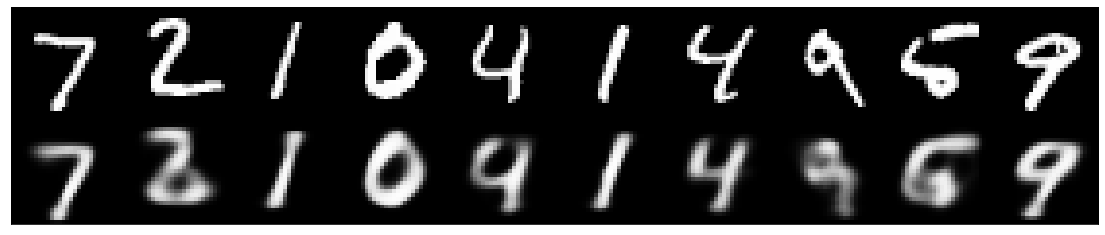

60000/60000 [==============================] - 24s - loss: 0.0863 - val_loss: 0.0765
Epoch 47/50
60000/60000 [==============================] - 21s - loss: 0.0863 - val_loss: 0.0766
Epoch 48/50
60000/60000 [==============================] - 21s - loss: 0.0863 - val_loss: 0.0766
Epoch 49/50
60000/60000 [==============================] - 21s - loss: 0.0863 - val_loss: 0.0766
Epoch 50/50
60000/60000 [==============================] - 21s - loss: 0.0862 - val_loss: 0.0766


In [ ]:
# Запуск обучения 
cvae.fit([x_train, y_train_cat, y_train_cat], x_train, shuffle=True, epochs=50,
         batch_size=batch_size,
         validation_data=([x_test, y_test_cat, y_test_cat], x_test),
         callbacks=[pltfig, tb],
         verbose=1) # грузим наши данные в модель, задаем параметры и обучаем

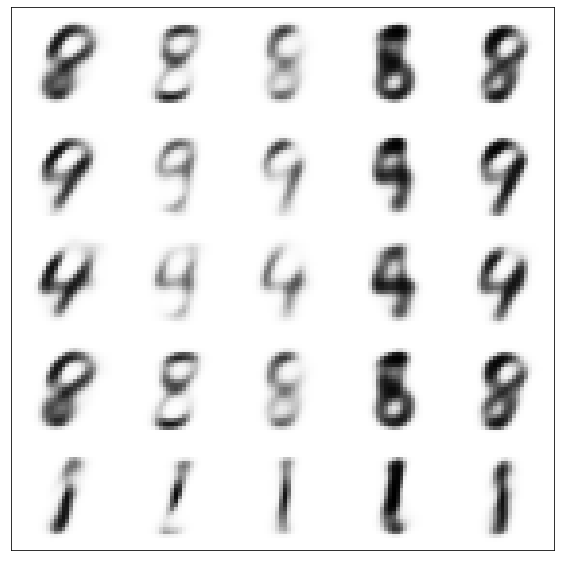

In [ ]:
n = 5 
lbl = np.random.randint(10) # зададим случайное значение лейбла (от 0 до 9)
generated = [] # здесь соберем список сгенерированных картинок
prot = x_train[y_train == lbl][:n] # будем передавать одно и тоже значение prot, лейбла заданного выше 

for i in range(n): # подаем значения 5 раз как указано в задании
    label = np.random.randint(10) # зададим случайное значение лейбла (от 0 до 9)
    generated.append(style_transfer(models["style_t"], prot, lbl, label)) # и генерим картинки с учетом переноса стиля

plot_digits(*generated, invert_colors=True) # отрисовываем картинки

**Итоги:**

Подав 5 раз один и тот же случайный вектор и случайный label (от 0 до 9) в результате мы получили сгенерированные цифры, разные по значению и одинаковые по стилю. 

P.S. так обучяется сеть очень долго, для данного задания я упростила CVAE и обучила меньше количество эпох, поэтому качество хромает. Но сути задания не мешает, а еще раз доказывает корреляцию уровня ошибки и качества изображения(чем ниже уровень ошибки, тем качественнее изображение)

## **PRO**

### **Вариант 1**

**Залание:**


Сделайте генерацию с помощью VAE баз Fashion mnist или Cifar10, покажите плавный переход из образа номер n в образ номер m




In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import sys 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.stats import norm 
from keras.datasets import fashion_mnist 


from keras.optimizers import Adam, RMSprop 
from keras.layers import Input, Dense, Conv2D
from keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda 
from keras.models import Model 

from keras.objectives import binary_crossentropy 
from keras.layers.advanced_activations import LeakyReLU 
from keras import backend as K 
from IPython.display import clear_output 
from keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard 

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data() 

x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255. 
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) 
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1)) 

In [ ]:
batch_size = 500 # размер батча
latent_dim = 10 # размер скрытого слоя/пространства
dropout_rate = 0.3 # размер слоя регуляризации, "выключим" указанное количество нейронов, во избежание переобучения
start_lr = 0.0001 # шаг обучения
img_shape = (28, 28, 1) # зармер картинки

In [ ]:
# объявляем функцию создания вариационного автокодировщика

def create_vae(): 
    models = {} 

    def apply_bn_and_dropout(x): 
        return Dropout(dropout_rate)(BatchNormalization()(x)) 

    # Энкодер
    input_img = Input(batch_shape=(batch_size, 28, 28, 1))
    x = Conv2D(4, (3,3), padding="same", input_shape=img_shape)
    x = Flatten()(input_img) 
    x = Dense(256, activation='relu')(x) 
    x = apply_bn_and_dropout(x) 
    x = Dense(256, activation='relu')(x) 
    x = apply_bn_and_dropout(x) 

    # Предсказываем параметры распределений
    # Вместо того, чтобы предсказывать стандартное отклонение, предсказываем логарифм вариации
    
    z_mean = Dense(latent_dim)(x) # скрытое пространство(мат.ожидание) размером 10
    
    z_log_var = Dense(latent_dim)(x) # скрытое пространство(лог.вариации) размером 10

    # Сэмплирование из Q с трюком репараметризации
    def sampling(args): # обьявляем функцию сэмплирования
        z_mean, z_log_var = args # принимаем в аргументах z_mean, z_log_var, раскусываем их
        
        # Керасовским методом делаем нормальное распределение(500 10тимерных), мат.ожидание 0, ст.отклонение 1
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # Задаем самописный слой, к-й принимает лист [z_mean, z_log_var], семплирует, и на выходе выдает размерность (10,)
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    models["encoder"]  = Model(input_img, l) # модель энкодера от входа до лямбда слоя
    
    models["z_meaner"] = Model(input_img, z_mean) # отдельная модель с путем от входа до z_mean
    
    models["z_lvarer"] = Model(input_img, z_log_var) # отдельная модель с путем от входа до z_log_var

    # Декодер
    z = Input(shape=(latent_dim, )) 
    x = Dense(256)(z) 
    x = LeakyReLU()(x) 
    x = apply_bn_and_dropout(x) 
    x = Dense(256)(x) 
    x = LeakyReLU()(x) 
    x = apply_bn_and_dropout(x) 
    x = Dense(28*28, activation='sigmoid')(x) 
    decoded = Reshape((28, 28, 1))(x) 

    models["decoder"] = Model(z, decoded) # собираем модель декодера
    
    # Cобираем вариационный автокодировщик, также двойное преобразование над входной картинкой(энкодер-декодер)
    models["vae"] = Model(input_img, models["decoder"](models["encoder"](input_img)))

    # объявляем самописную функцию потерь
    def vae_loss(x, decoded): 
        x = K.reshape(x, shape=(batch_size, 28*28)) 
        decoded = K.reshape(decoded, shape=(batch_size, 28*28)) 
        xent_loss = 28*28*binary_crossentropy(x, decoded) 
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
        return (xent_loss + kl_loss)/2/28/28 # функция вернет суммарную ошибку с учетом распределения и размеров пикселей

    return models, vae_loss

models, vae_loss = create_vae() # получаем модели и свою функцию потерь
vae = models["vae"] # задаем модель вариационного автокодировщика

In [ ]:
vae.compile(optimizer=Adam(start_lr), loss=vae_loss) # компилируем модель с выбранным оптимайзером и своей функцией потерь

In [ ]:
digit_size = 28 # задаем размеры изобоажений

# функция отрисует две линии картинок - оригинальные и выходные из автокодировщика
def plot_digits(*args, invert_colors=False): 
    args = [x.squeeze() for x in args]  
    n = min([x.shape[0] for x in args])
    figure = np.zeros((digit_size * len(args), digit_size * n)) 

    for i in range(n):
        for j in range(len(args)): # заполняем фигуру значениями
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    if invert_colors: # если значение invert_colors будет True
        figure = 1-figure # то фигуру делаем обратной

    plt.figure(figsize=(2*n, 2*len(args))) 
    plt.imshow(figure, cmap='Greys_r') # выведем ее на экран в указанных цветах
    plt.grid(False) 
    ax = plt.gca() 
    ax.get_xaxis().set_visible(False) 
    ax.get_yaxis().set_visible(False) 
    plt.show() # выводим отрисованное на экран


In [ ]:
# Массивы, в которые будем сохранять результаты, для последующей визуализации
latent_distrs = []
epochs = []

# Эпохи, в которые будем сохранять
save_epochs = set([i*5 for i in range(0,25)])

imgs = x_test[:batch_size]
n_compare = 10

# Модели
generator      = models["decoder"]
encoder_mean   = models["z_meaner"]

# Функция, которую будем запускать после каждой эпохи
def on_epoch_end(epoch, logs):
    if epoch in save_epochs:
        clear_output() # Не захламляем output

        # Сравнение реальных и декодированных изображений
        decoded = vae.predict(imgs, batch_size=batch_size)
        plot_digits(imgs[:n_compare], decoded[:n_compare])

        # Сохранение многообразия и распределения z для создания анимации после
        epochs.append(epoch)
        latent_distrs.append(encoder_mean.predict(x_test, batch_size))
        
# Коллбэки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)

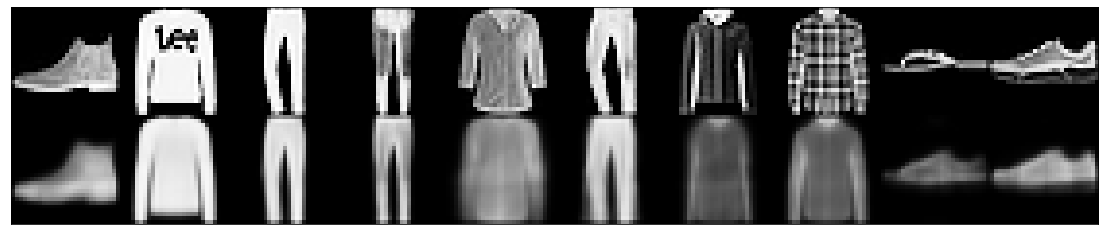

Epoch 97/100
60000/60000 [==============================] - 10s 166us/step - loss: 0.1643 - val_loss: 0.1597
Epoch 98/100
60000/60000 [==============================] - 10s 167us/step - loss: 0.1643 - val_loss: 0.1597
Epoch 99/100
60000/60000 [==============================] - 10s 166us/step - loss: 0.1642 - val_loss: 0.1597
Epoch 100/100
60000/60000 [==============================] - 10s 169us/step - loss: 0.1642 - val_loss: 0.1596


In [ ]:
# Запуск обучения 
vae.fit(x_train, x_train, shuffle=True, epochs=100,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        callbacks=[pltfig],
        verbose=1) # грузим наши данные в модель, задаем параметры и обучаем

In [ ]:
def plot_images(generator, examples=9, dim=(10,10), figsize=(20,20)): # функция добавляет шум на скрытом пространстве
    k = 1.1
    noise = np.random.normal(loc=0, scale=1, size=[1, latent_dim]) # создаем шум нормальным распределением
    
    im_arr = [generator.predict((k**i)*noise) for i in range(0,examples)] # получаем сгенеренные выходные картинки над заданным шумом
    im_arr = np.array(im_arr).reshape(examples,28,28) 

    plt.figure(figsize=figsize) # задаем способ отрисовки картинок
    for i in range(im_arr.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(im_arr[i], interpolation='nearest')
        plt.axis('off')
        plt.gray()
    plt.tight_layout()

**Посмотрим на генерацию обьектов**

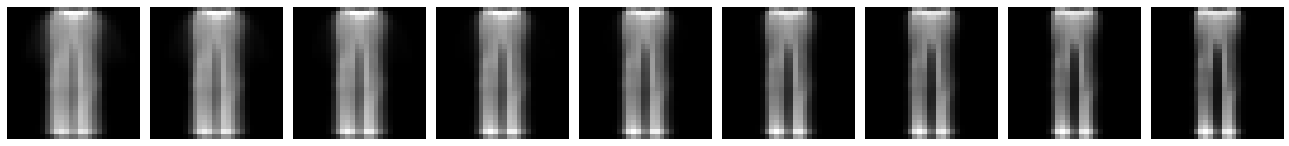

In [ ]:
plot_images(generator) # отрисовываем картинки 

In [ ]:
def plot_images_two_points(generator, examples=10, dim=(10,10), figsize=(15,15)):
    
    noise1 = 1*np.random.normal(loc=0, scale=1, size=[1, latent_dim]) # создаем первое случайное зашумленное распределение
    noise2 = 1*np.random.normal(loc=0, scale=1, size=[1, latent_dim]) # создаем второе случайное зашумленное распределение
    
    # получаем сгенеренные выходные картинки плавным переходом от одного зашумленного к другому 
    im_arr = [generator.predict(i*noise2/(examples-1) + (examples-i-1)*noise1/(examples-1)) for i in range(0,examples)]
    im_arr = np.array(im_arr).reshape(examples,28,28) 

    plt.figure(figsize=figsize) # задаем способ отрисовки картинок
    for i in range(im_arr.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(im_arr[i], interpolation='nearest', )
        plt.axis('off')
    plt.tight_layout()

**Посмотрим как один предмет одежды плавно перетекает в другой**


1. из ботинка в футболку  
2. из сумки в футболку

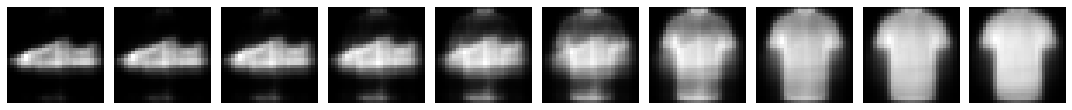

In [ ]:
plot_images_two_points(generator) # отрисовываем картинки 

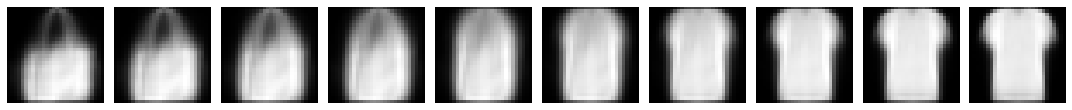

In [ ]:
plot_images_two_points(generator) # отрисовываем картинки

In [ ]:
z_imgs = models['encoder'].predict(x_test[:500], batch_size=500)

In [ ]:
print(z_imgs.shape)

(500, 10)


In [ ]:
def plot_images_two_points2(generator, z_imgs, examples=10, dim=(10,10), figsize=(15,15)):
    
    index1 = int(round(200*np.random.sample(1)[0])) # запишем в первый индекс случайно сгенерированное значение
    index2 = int(round(200*np.random.sample(1)[0])) # запишем во второй индекс случайно сгенерированное значение
    noise1 = z_imgs[index1,:].reshape(1,10) # сгенерируем первую зашумленную картинку по полученному индексу
    noise2 = z_imgs[index2,:].reshape(1,10) # сгенерируем вторую зашумленную картинку по полученному индексу
    
    # получаем сгенеренные выходные картинки плавным переходом от одного зашумленного к другому 
    im_arr = [generator.predict(i*noise2/(examples-1) + (examples-i-1)*noise1/(examples-1)) for i in range(0,examples)]
    im_arr = np.array(im_arr).reshape(examples,28,28) 

    plt.figure(figsize=figsize) # задаем способ отрисовки картинок
    for i in range(im_arr.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(im_arr[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()

**Рассмотрим побольше разных вариантов перетикания**

1. из брюк к ботинок
2. из свитора в ботинок
3. из брюк в свитер
4. из футболки в сумку

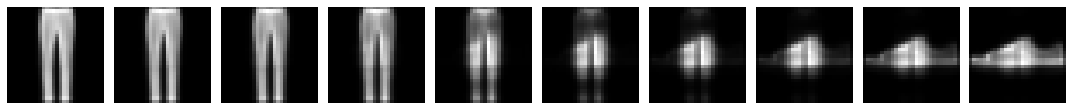

In [ ]:
plot_images_two_points2(generator, z_imgs, examples=10) # отрисовываем картинки 

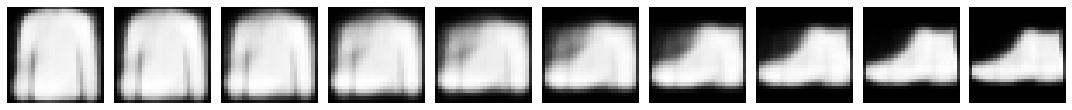

In [ ]:
plot_images_two_points2(generator, z_imgs, examples=10) # отрисовываем картинки 

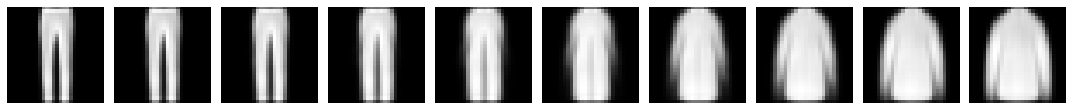

In [ ]:
plot_images_two_points2(generator, z_imgs, examples=10) # отрисовываем картинки 

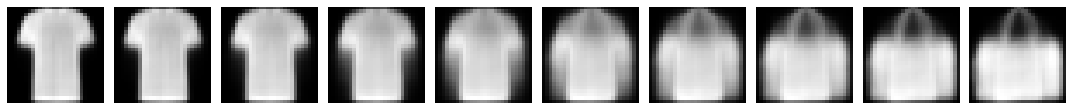

In [ ]:
plot_images_two_points2(generator, z_imgs, examples=10) # отрисовываем картинки 

**И более плавное перетекание**
из ботинка в свитер

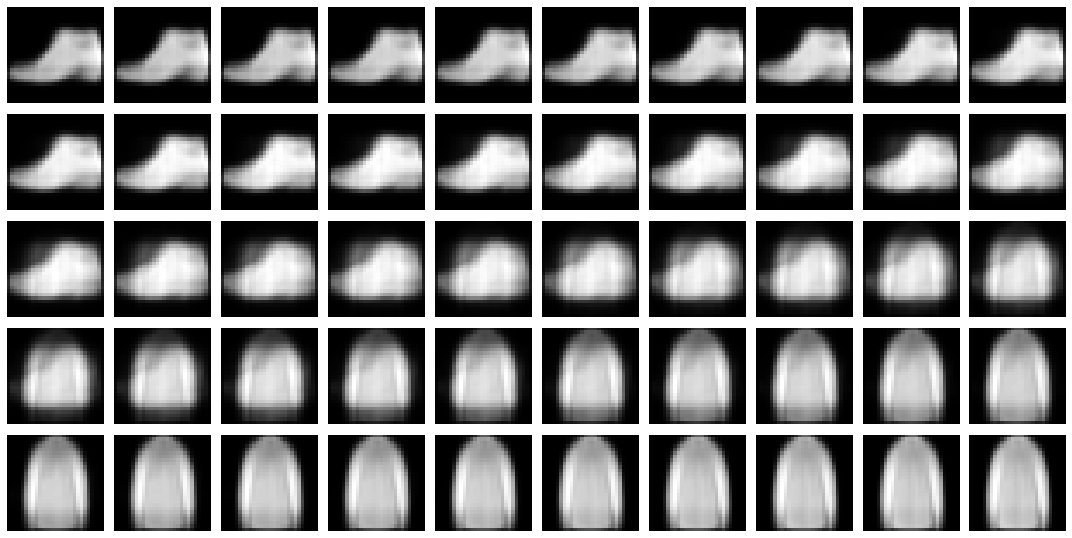

In [ ]:
plot_images_two_points2(generator, z_imgs, examples=50) # отрисовываем картинки 

**Как видно сгенерированные картинки получились вполне неплохими, а переход из образа номер n в номер m происходит гладко. В более плавном переходе (50 картинок) четко прослеживается гладкий переход из одного образа в другой.**